In [70]:
import numpy as np
from service import train
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [71]:
# define base data, label store path
base_data_path = train.base_data_path
base_label_path = train.base_label_path

# define new data store path
new_data_path = train.new_data_path

Load base train data set

In [72]:
with open(f'{base_data_path}labels.txt', 'r') as f:
    lines = f.readlines()
    base_actions = [line.strip().split()[0] for line in lines]
    base_labels = [line.strip().split()[1] for line in lines]

base_data = np.concatenate([
   np.load(f'{base_data_path}seq_{action}.npy') for action in base_actions
], axis=0)

base_actions, base_labels, base_data.shape

(['clenching', 'away', 'come'], ['0', '1', '2'], (632, 30, 100))

Load new train data set

In [73]:
with open(f'{new_data_path}labels.txt', 'r') as f:
    lines = f.readlines()
    new_actions = [line.strip().split()[0] for line in lines]
    new_labels = [line.strip().split()[1] for line in lines]

new_data = np.concatenate([
   np.load(f'{new_data_path}seq_{action}.npy') for action in new_actions
], axis=0)

new_actions, new_labels, new_data.shape

(['twoFinger'], ['3'], (206, 30, 100))

Combine train set

In [74]:
comb_data = np.concatenate([base_data, new_data])
comb_actions = np.concatenate([base_actions, new_actions])
comb_labels = np.concatenate([base_labels, new_labels])

comb_data.shape, comb_actions, comb_labels

((838, 30, 100),
 array(['clenching', 'away', 'come', 'twoFinger'], dtype='<U9'),
 array(['0', '1', '2', '3'], dtype='<U1'))

Make train set, one-hot-encoding

In [75]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

x_data = comb_data[:, :, :-1]
labels = comb_data[:, 0, -1]

y_data = to_categorical(labels, num_classes=len(comb_actions))

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=2022)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((670, 30, 99), (670, 4), (168, 30, 99), (168, 4))

Add model summary

In [85]:
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, LSTM

# base_model = load_model('models/base_model.h5')

# # Load pre-trained model
# pretrained_model = Sequential()
# pretrained_model.add(LSTM(64, activation='relu', input_shape=x_train.shape[1:3]))
# pretrained_model.add(Dense(32, activation='relu'))
# pretrained_model.add(Dense(16, activation='relu'))
# pretrained_model.add(Dense(3, activation='softmax'))
# pretrained_model.load_weights('models/base_model.h5')

# new_output_layer = Dense(len(comb_actions), activation='softmax')(pretrained_model.layers[-2].output)

# model = Model(inputs=pretrained_model.input, outputs=new_output_layer)

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(comb_actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 64)                41984     
                                                                 
 dense_57 (Dense)            (None, 64)                4160      
                                                                 
 dense_58 (Dense)            (None, 32)                2080      
                                                                 
 dense_59 (Dense)            (None, 4)                 132       
                                                                 
Total params: 48,356
Trainable params: 48,356
Non-trainable params: 0
_________________________________________________________________


Train Model fit

In [86]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/testmodel.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto'),
    ]
)

Epoch 1/200
21/21 [==============================] - ETA: 0s - loss: 91.4786 - acc: 0.3985
Epoch 1: val_acc improved from -inf to 0.44048, saving model to models\testmodel.h5
21/21 [==============================] - 3s 94ms/step - loss: 91.4786 - acc: 0.3985 - val_loss: 12.1917 - val_acc: 0.4405 - lr: 0.0010
Epoch 2/200
21/21 [==============================] - ETA: 0s - loss: 8.0077 - acc: 0.5358
Epoch 2: val_acc improved from 0.44048 to 0.55357, saving model to models\testmodel.h5
21/21 [==============================] - 2s 98ms/step - loss: 8.0077 - acc: 0.5358 - val_loss: 8.4993 - val_acc: 0.5536 - lr: 0.0010
Epoch 3/200
21/21 [==============================] - ETA: 0s - loss: 7.0806 - acc: 0.5791
Epoch 3: val_acc did not improve from 0.55357
21/21 [==============================] - 2s 93ms/step - loss: 7.0806 - acc: 0.5791 - val_loss: 8.9438 - val_acc: 0.5298 - lr: 0.0010
Epoch 4/200
21/21 [==============================] - ETA: 0s - loss: 7.6200 - acc: 0.5552
Epoch 4: val_acc impr

KeyboardInterrupt: 

Show result graph

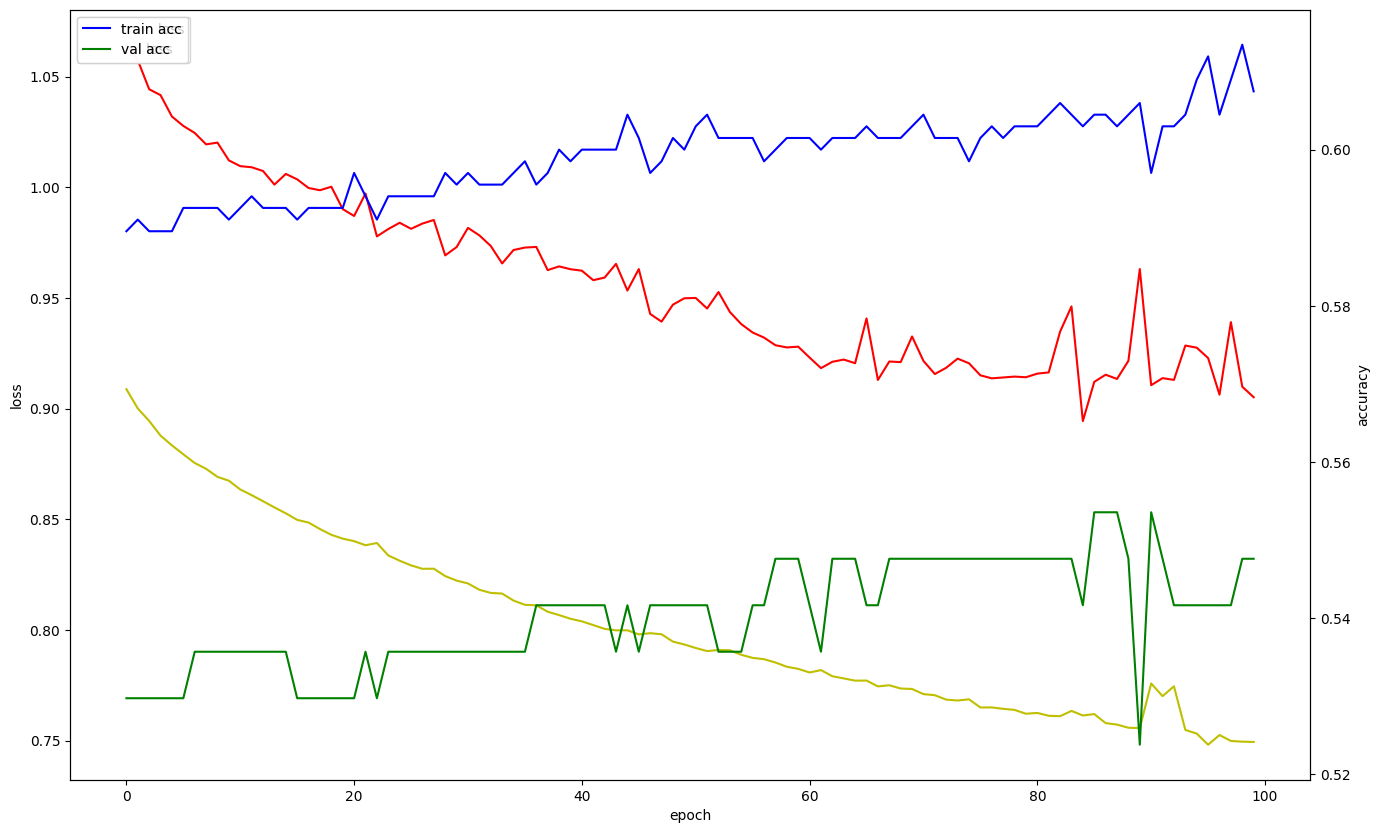

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()